In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

r = requests.get(url, allow_redirects=True)

with open('Data/course_lead_scoring.csv', 'wb') as f:
    f.write(r.content)
    
r.status_code

200

In [2]:
df= pd.read_csv('Data/course_lead_scoring.csv')
df.head(3)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1


In [18]:
def prepare_data(df: pd.DataFrame, train_size, val_size, test_size, seed: int = 42):

    # Categorical features
    cat_cols = df.select_dtypes(include=['object']).columns
    df[cat_cols] = df[cat_cols].fillna('NA')
    # Numerical features
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(0)

    # df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    X = df.drop(columns=['converted'])
    y = df['converted']

    X_train, X_temp, y_train, y_temp = train_test_split(
                                    X, y, test_size = (1 - train_size), 
                                    random_state=seed, 
                                    )

    X_val, X_test, y_val, y_test = train_test_split(
                                X_temp, y_temp, test_size = (test_size / (val_size + test_size)), 
                                random_state=seed, 
                                )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [57]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df, train_size = 0.6, val_size = 0.2, test_size = 0.2)

###Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.\
Use the training dataset for that\
If your AUC is < 0.5, invert this variable by putting "-" in front\

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [47]:
from sklearn.metrics import roc_auc_score

num_cols = X_train.select_dtypes(include=['number']).columns.to_list()

auc_scores = {}

for var in num_cols:
    auc = roc_auc_score(y_train, X_train[var])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[var])
    auc_scores[var] = auc

auc_scores

{'number_of_courses_viewed': 0.7676094441711755,
 'annual_income': 0.5204705689457287,
 'interaction_count': 0.7188992731048807,
 'lead_score': 0.6281876810406076}

### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)\
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [48]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)
train_dict = X_train.to_dict(orient='records')
X_train_vect = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_vect, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
val_dict = X_val.to_dict(orient='records')
X_val_vect = dv.transform(val_dict)

y_pred = model.predict_proba(X_val_vect)[:, 1]
model_auc = roc_auc_score(y_val, y_pred)
round(model_auc, 3)

0.775

### Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01\
For each threshold, compute precision and recall\
Plot them\
At which threshold precision and recall curves intersect?

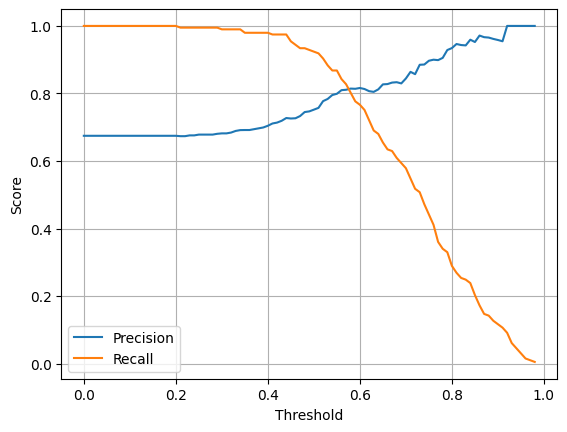

Threshold interseccion recall and precision: 0.58


In [43]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 0.99, 0.01)
precisions = []
recalls = []
for t in thresholds:
    y_pred_threshold = (y_pred >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred_threshold, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_threshold, zero_division=0))

idx = np.argmin(np.abs(np.array(precisions) - np.array(recalls)))
thresholds[idx]

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()
print(f'Threshold interseccion recall and precision: {thresholds[idx]}')

### Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [45]:
from sklearn.metrics import f1_score

f1_scores = []
for t in thresholds:
    y_pred_threshold = (y_pred >= t).astype(int)
    f1 = f1_score(y_val, y_pred_threshold, zero_division=0)
    f1_scores.append(f1)

max_f1 = max(f1_scores)
max_f1

0.8356807511737089

### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)\
Iterate over different folds of df_full_train\
Split the data into train and validation\
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)\
Use AUC to evaluate the model on validation\
How large is standard deviation of the scores across different folds?

In [50]:
from sklearn.model_selection import KFold

def train(X_train, y_train):

    dv = DictVectorizer(sparse=False)
    train_dict = X_train.to_dict(orient='records')
    X_train_vect = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_vect, y_train)

    return dv, model

In [51]:
dv, model = train(X_train, y_train)

In [52]:
def predict(X_val, dv, model):

    val_dict = X_val.to_dict(orient='records')
    X_val_vect = dv.transform(val_dict)

    y_pred = model.predict_proba(X_val_vect)[:, 1]
    
    return y_pred

In [59]:
y_pred = predict(X_val, dv, model)

In [60]:
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)

# full_train
df_full_train = pd.concat([df_train, df_val], axis=0).reset_index(drop=True)

In [63]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in k_fold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    y_train = df_train.converted.values


    df_val = df_full_train.iloc[val_idx]
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    model_auc = roc_auc_score(y_val, y_pred)
    scores.append(model_auc)

In [66]:
print('auc = %0.3f ± %0.3f' % (np.mean(scores), np.std(scores)))

auc = 0.879 ± 0.011


### Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]\
Initialize KFold with the same parameters as previously\
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)\
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)\
Which C leads to the best mean score?

In [67]:
def train_C(X_train, y_train, C):

    dv = DictVectorizer(sparse=False)
    train_dict = X_train.to_dict(orient='records')
    X_train_vect = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train_vect, y_train)

    return dv, model

In [68]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train_C(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=1e-06, auc = 0.546 ± 0.024
C=0.001, auc = 0.920 ± 0.017
C=1, auc = 0.879 ± 0.011
